In [1]:
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

# to re-load loaddata,helper and model if changes happened 
%load_ext autoreload
%autoreload 2

from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader
from loaddata import FacialKeyPointsDataset , Rescale , Normalize , RandomCrop , ToTensor
from helper import show_keypoints , visualize_output
from model import Net


In [2]:
model = Net().cuda()
print(model)

Net(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, padd

In [3]:
tranform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
batch_size = 20
# train data
traindata = FacialKeyPointsDataset('data/training/','data/training_frames_keypoints.csv',transform=tranform)
train_loader = DataLoader(traindata,batch_size=batch_size,shuffle=True)
#test Data
testdata = FacialKeyPointsDataset('data/test/','data/test_frames_keypoints.csv',transform=tranform)
test_loader = DataLoader(testdata,batch_size=batch_size,shuffle=True)

In [4]:
# some Info about data 
print("Number of training images is : ",len(traindata))
print("shape of training images is :",traindata[0][0].shape)
print("Number if test images is :",len(testdata))

Number of training images is :  3462
shape of training images is : (1, 224, 224)
Number if test images is : 770


### test mode  in test data before training 

In [5]:
iterator = iter(test_loader)
images , keypts = iterator.next()
images , keypts = images.type(torch.cuda.FloatTensor), keypts.type(torch.cuda.FloatTensor)
outs = model(images)

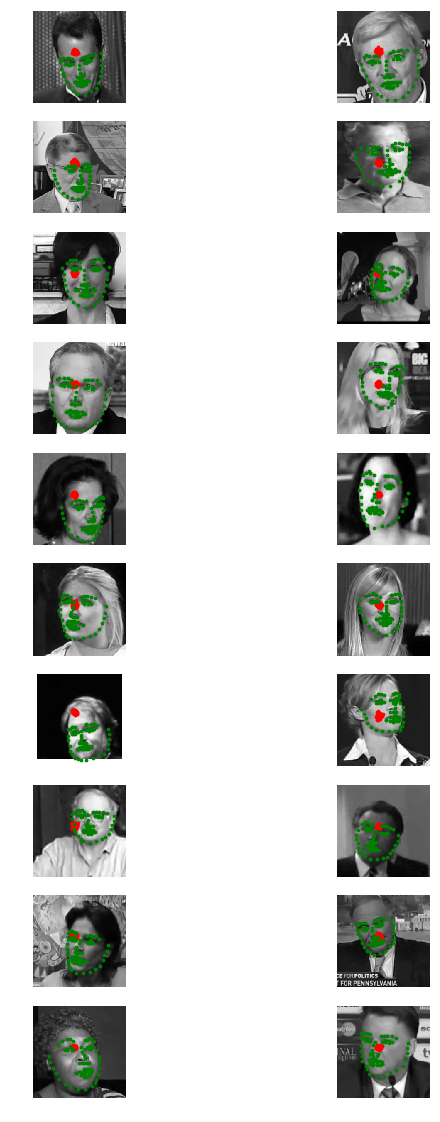

In [6]:
# plot results 
visualize_output(images,outs,batch_size,gt=keypts,gray=True)

In [4]:
# set training parameters 
cost = nn.MSELoss()
opt = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,nesterov=True)

In [5]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        epoch_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images ,keypts = data

            # flatten pts
            keypts = keypts.view(keypts.size(0), -1)

            # convert variables to floats for regression loss
            keypts = keypts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = cost(output_pts, keypts)

            # zero the parameter (weight) gradients
            opt.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            opt.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_loss += running_loss
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        print('----------------\nEpoch loss: {}\n------------\n'.format(epoch_loss/170))
    print('Finished Training')


In [6]:
epoches = 1 # small to tesp model is working before training 
train_net(epoches)

Epoch: 1, Batch: 10, Avg. Loss: 0.5826267123222351
Epoch: 1, Batch: 20, Avg. Loss: 0.22934384047985076
Epoch: 1, Batch: 30, Avg. Loss: 0.21725098937749862
Epoch: 1, Batch: 40, Avg. Loss: 0.20598232746124268
Epoch: 1, Batch: 50, Avg. Loss: 0.17997481673955917
Epoch: 1, Batch: 60, Avg. Loss: 0.17437979727983474
Epoch: 1, Batch: 70, Avg. Loss: 0.1887873724102974
Epoch: 1, Batch: 80, Avg. Loss: 0.19140715003013611
Epoch: 1, Batch: 90, Avg. Loss: 0.2196117728948593
Epoch: 1, Batch: 100, Avg. Loss: 0.18743583858013152
Epoch: 1, Batch: 110, Avg. Loss: 0.1678521826863289
Epoch: 1, Batch: 120, Avg. Loss: 0.19641995504498483
Epoch: 1, Batch: 130, Avg. Loss: 0.22528957426548005
Epoch: 1, Batch: 140, Avg. Loss: 0.20153303518891336
Epoch: 1, Batch: 150, Avg. Loss: 0.19792176485061647
Epoch: 1, Batch: 160, Avg. Loss: 0.18961476236581803
Epoch: 1, Batch: 170, Avg. Loss: 0.1924091711640358
----------------
Epoch loss: 1.2792662089800133
------------

Finished Training
